Import the fastai library.

In [1]:
from fastai import *
from fastai.vision import *

Path to dataset

In [2]:
path = Path('/notebooks/storage/dataset'); path

PosixPath('/notebooks/storage/dataset')

In [3]:
df = pd.read_csv(path/'train.csv')
df.head()

,Image,target
0,96.jpg,manipuri
1,163.jpg,bharatanatyam
2,450.jpg,odissi
3,219.jpg,kathakali
4,455.jpg,odissi


Create a fastai databunch out of 'train' folder. Label the images in 'train' with the csv, split the 'train' randomly in 85/15 train/valid, transform all train images, resize valid images (no other transform) for valid set, create batchsize of 64 images, apply imagenet nomalization.

In [4]:
src = (ImageList.from_csv(path,'train.csv',folder='train',label_cls=CategoryList)
       .split_by_rand_pct(0.15,seed=167)
       .label_from_df(label_delim=' ')
       .add_test_folder());src

LabelLists;

Train: LabelList (310 items)
x: ImageList
Image (3, 183, 276),Image (3, 444, 330),Image (3, 283, 220),Image (3, 190, 266),Image (3, 827, 1170)
y: CategoryList
bharatanatyam,odissi,kathakali,odissi,kathak
Path: /notebooks/storage/dataset;

Valid: LabelList (54 items)
x: ImageList
Image (3, 742, 500),Image (3, 450, 900),Image (3, 330, 220),Image (3, 187, 269),Image (3, 267, 188)
y: CategoryList
mohiniyattam,kathak,mohiniyattam,manipuri,mohiniyattam
Path: /notebooks/storage/dataset;

Test: LabelList (156 items)
x: ImageList
Image (3, 213, 237),Image (3, 600, 421),Image (3, 240, 210),Image (3, 517, 515),Image (3, 2281, 1931)
y: EmptyLabelList
,,,,
Path: /notebooks/storage/dataset

In [5]:
tfms = get_transforms(max_warp=0.,max_zoom=0.3,max_rotate=30)


In [6]:
data = (src.transform(tfms,size=100).databunch(bs=64).normalize(imagenet_stats))

Show images along with labels.

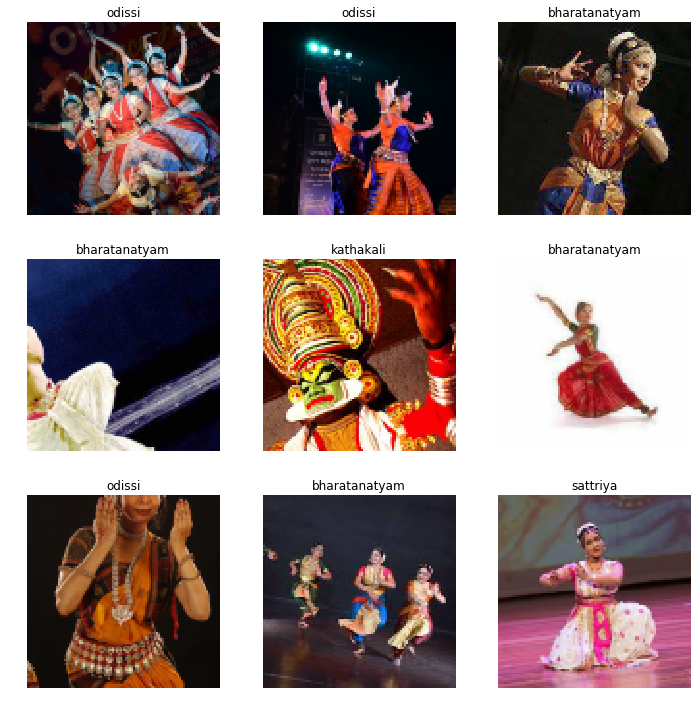

In [7]:
data.show_batch(rows=3,figsize=(10,10))

In [7]:
data.classes

['bharatanatyam',
 'kathak',
 'kathakali',
 'kuchipudi',
 'manipuri',
 'mohiniyattam',
 'odissi',
 'sattriya']

Use pretrained resnet 50.

In [8]:
arc=models.resnet50

Configure fastai learner so as to show error_rate and F1 score of valid set

In [9]:
fbeta = FBeta(average='weighted',beta=1)
learn = cnn_learner(data, arc, metrics=[error_rate,fbeta])

Find the learning rate at which the slope of loss and learning rate is steepest for first train step.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.74E-03
Min loss divided by 10: 8.32E-03


0.001737800828749376

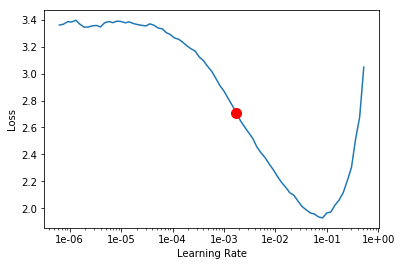

In [10]:
learn.lr_find()
learn.recorder.plot(suggestion=True)
min_grad_lr = learn.recorder.min_grad_lr
min_grad_lr

Do 5 epochs and use the One Cycle Policy (learning rate rises upto a max value and then falls i.e use differential learning).
Also train only the later layers of the model in the first step.

In [11]:
learn.fit_one_cycle(5,slice(1.73e-03))

epoch,train_loss,valid_loss,error_rate,f_beta,time
0,3.122850,2.688831,0.740741,0.152388,00:02
1,2.601559,2.406354,0.592593,0.310936,00:03
2,2.191541,1.948286,0.518519,0.454012,00:02
3,1.882561,1.675468,0.444444,0.538457,00:02
4,1.642961,1.562068,0.425926,0.555229,00:03


Now unfreeze whole model and again find the learning rate for the next step.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


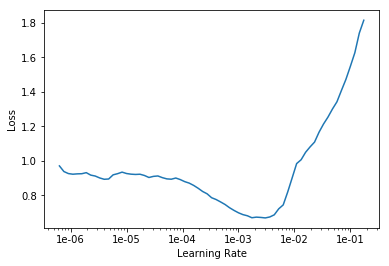

In [12]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [30]:
learn.unfreeze()

In [13]:
learn.fit_one_cycle(5,slice(1.73e-04,2e-03))

epoch,train_loss,valid_loss,error_rate,f_beta,time
0,0.865285,1.282614,0.351852,0.639730,00:03
1,0.786450,2.435751,0.333333,0.652347,00:02
2,0.876951,2.996364,0.388889,0.644085,00:02
3,0.826725,1.802524,0.333333,0.692728,00:02
4,0.783299,1.356489,0.314815,0.693873,00:02


Now in the third step, keep all the transfomations same, just the resize the images from 100 to 244. Then change the data of our 'learn' object instead of instantiating a new learner object. What this essentially means is that we are doing transfer learning on the model that we trained in step 2.

In [14]:
data=(src.transform(tfms,size=244).databunch(bs=64).normalize(imagenet_stats))

In [15]:
learn.data = data

Again freeze whole model and train only the later layers.

In [16]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


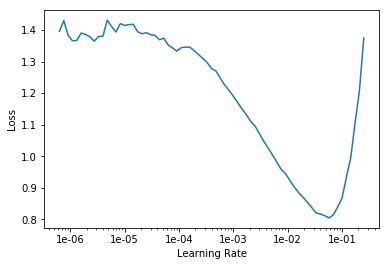

In [17]:
learn.lr_find()
learn.recorder.plot()

In [18]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate,f_beta,time
0,1.333293,1.071961,0.351852,0.648664,00:06
1,1.058362,1.053964,0.351852,0.649647,00:04
2,0.865210,0.773779,0.185185,0.811696,00:05
3,0.749860,0.709644,0.111111,0.885538,00:04
4,0.670727,0.693668,0.148148,0.852934,00:05


Now in step 4 train whole model.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


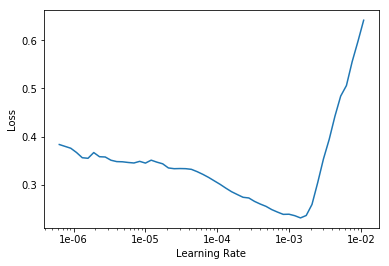

In [20]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [21]:
learn.unfreeze()
learn.fit_one_cycle(5,slice(1e-04,1e-03))

epoch,train_loss,valid_loss,error_rate,f_beta,time
0,0.446917,0.644157,0.185185,0.811492,00:06
1,0.307434,0.873145,0.148148,0.850065,00:05
2,0.287726,0.966286,0.166667,0.824532,00:05
3,0.262965,0.944880,0.185185,0.811060,00:05
4,0.232801,0.879468,0.148148,0.852457,00:05


step 5 and 6 same as 3 and 4

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


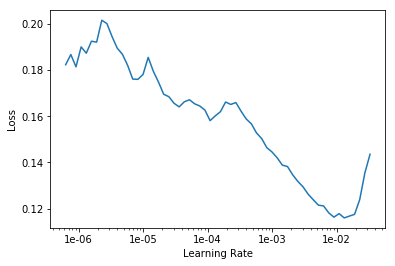

In [23]:
data=(src.transform(tfms,size=299).databunch(bs=64).normalize(imagenet_stats))
learn.data = data
learn.freeze()
learn.lr_find()
learn.recorder.plot()

In [24]:
learn.fit_one_cycle(3,slice(1e-03))

epoch,train_loss,valid_loss,error_rate,f_beta,time
0,0.154162,0.809848,0.148148,0.850348,00:08
1,0.116027,0.811991,0.166667,0.831829,00:06
2,0.110958,0.806530,0.166667,0.831829,00:05


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


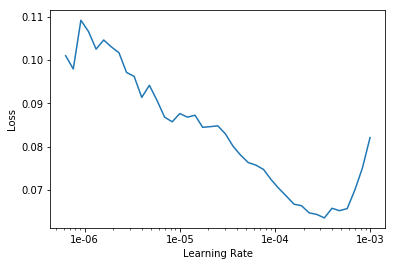

In [26]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()


In [33]:
learn1 = learn

In [34]:
#learn.unfreeze()
learn1.fit_one_cycle(1,slice(2e-05,2e-04))

epoch,train_loss,valid_loss,error_rate,f_beta,time
0,0.066350,0.595641,0.129630,0.860815,00:07


get the predictions on test set then create a dictionary with keys as image names and values as predictions and save to csv.

In [35]:
preds,y = learn1.get_preds(ds_type=DatasetType.Test)
output_dict = dict()
fnames = []
for f in learn.data.test_ds.items:
    fnames.append(f.name[:-4])
for i in range (len(preds)):
    indx = np.argmax(preds[i]).item()
    prediction = str(preds[i][indx].item())
    output_dict.update({fnames[i]+'.jpg':data.classes[indx]})
df = pd.DataFrame({'Image':list(output_dict.keys()), 'target':list(output_dict.values())}, columns=['Image', 'target'])
df.to_csv(path/'submission-new(2).csv', index=False)
df.head()

,Image,target
0,416.jpg,kuchipudi
1,473.jpg,odissi
2,217.jpg,kathakali
3,216.jpg,kathakali
4,114.jpg,bharatanatyam


Save the model weights and export transforms, classes, normalizations, etc. Model weight is in a .pth file while export is in .pkl file.

In [36]:
learn.save('stage-5-resnet50')
learn.export('stage-5-resnet50')